In [22]:
import pandas as pd
import numpy as np 
from utils import compare_counts, compare_hists

# train_csv_path = "data/train.csv"
train_csv_path = "data/processed/df_outliers_removed.csv"

frame = pd.read_csv(train_csv_path)

In [23]:
X = frame.drop("loan_paid_back", axis=1)
y = frame["loan_paid_back"]


In [24]:
X.shape

(535736, 11)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Simple baseline model


Since target feature is imbalanced (almost 80% loans are paid) the simplest baseline model will be model that always return True

In [5]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)

,strategy,'most_frequent'
,random_state,None
,constant,None


In [6]:
dummy_model.score(X_train, y_train)

0.8024256395419377

In [7]:
dummy_model.score(X_val, y_val)

0.8012095419419868

# Important!!!

dummy_model cannot be used for real predictions. It's not 2008 and we definitely do not want to create another financial crisis ;)

# Data preparation

## Defining pipelines

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer


class Log1pImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        
    def fit(self, X: pd.DataFrame, y=None):
        self.imputer_.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame):
        X_out = self.imputer_.transform(X)

        if np.nanmin(X_out) < -1:
            raise ValueError("Log1pImuter values must be >= -1")
        return np.log1p(X_out)
    

class RatioInteractionImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        
    def fit(self, X: pd.DataFrame, y=None):
        self.imputer_.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame):
        X_out = self.imputer_.transform(X)
        X_out["rate_per_score"] = X_out["intrest_rate"] / X_out["credit_score"]
        X_out["inter_cs_ir"] = X_out["intrest_rate"] * X_out["credit_score"]

        return X_out


one_hot_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ord_categories = [
    ['F5','F4','F3','F2','F1','E5','E4','E3','E2','E1','D5','D4','D3','D2','D1','C5','C4','C3','C2','C1','B5','B4','B3','B2','B1','A5','A4','A3','A2','A1'],
]
ordinal_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ord_enc", OrdinalEncoder(categories=ord_categories,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1))
])

log1p_pipe = Pipeline(steps=[
    ("log1p", Log1pImputer(strategy="median"))
])

numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])

one_hot_cols = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']
ordinal_cols = ['grade_subgrade']
numeric_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
log1p_cols = ['annual_income', 'debt_to_income_ratio', 'loan_amount']
preprocess = ColumnTransformer(
    transformers=[
        ("onehot", one_hot_pipe, one_hot_cols),
        ("ordinal", ordinal_pipe, ordinal_cols),
        ("log1p", log1p_pipe, log1p_cols),
        ("num", numeric_pipe, numeric_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [32]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500)

full_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", log_reg)
])

full_pipe.fit(X_train, y_train)

d:\Programowanie\Kaggle\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('ordinal', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


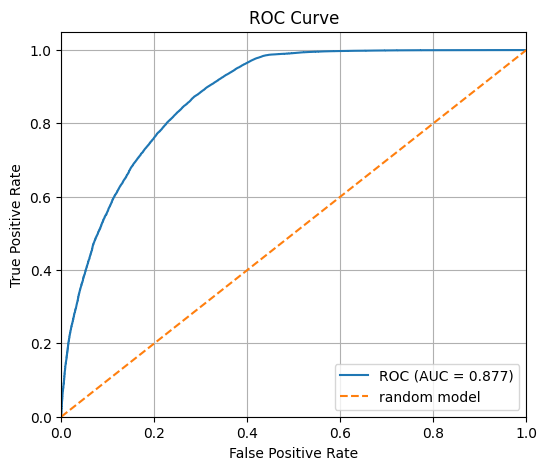

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba = full_pipe.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)


plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="random model")
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Model selection

# Model tuning

# Model evaluation